In [4]:
!pip install --upgrade fsspec==2024.10.0

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
    Uninstalling fsspec-2024.9.0:
      Successfully uninstalled fsspec-2024.9.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.1.0 requires fsspec[http]<=2024.9.0,>=2023.1.0, but you have fsspec 2024.10.0 which is incompatible.


In [5]:
!pip install "datasets==3.1.0" "fsspec<=2024.9.0,>=2023.1.0" "gcsfs<2024.10.0"

  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install datasets

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from sklearn.utils import resample, shuffle

C:\Users\Dua Zahra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load your datasets
d_path = r"D:\Project\d_tweets.csv"
non_d_path = r"D:\Project\non_d_tweets.csv"

d_tweet_df = pd.read_csv(d_path)
non_d_tweet_df = pd.read_csv(non_d_path)

# Remove empty rows
d_tweet_df = d_tweet_df[d_tweet_df['tweet'].notna()]
non_d_tweet_df = non_d_tweet_df[non_d_tweet_df['tweet'].notna()]

# Assign labels
non_d_tweet_df['label'] = 0
d_tweet_df['label'] = 1

# Combine datasets and shuffle
tweet_df = pd.concat([d_tweet_df[['tweet', 'label']], non_d_tweet_df[['tweet', 'label']]])
tweet_df = shuffle(tweet_df).reset_index(drop=True)

# Identify majority and minority classes
majority_class = tweet_df[tweet_df['label'] == tweet_df['label'].mode()[0]]
minority_class = tweet_df[tweet_df['label'] != tweet_df['label'].mode()[0]]

# Undersample the majority class
majority_undersampled = resample(majority_class,
                                 replace=False,    # sampling without replacement
                                 n_samples=len(minority_class),  # match minority class size
                                 random_state=42)  # reproducible results

# Combine the undersampled majority class with the minority class
tweet_df = pd.concat([majority_undersampled, minority_class])

# Shuffle the balanced dataset
tweet_df = shuffle(tweet_df).reset_index(drop=True)






In [3]:
print(tweet_df['label'].value_counts())


label
0    3496
1    3496
Name: count, dtype: int64


In [4]:
# Split the dataset
train_data, val_data = train_test_split(tweet_df, test_size=0.2, stratify=tweet_df['label'], random_state=42)


In [5]:
# Convert Pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)


In [6]:
# Load pre-trained BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


In [7]:
# Define a preprocessing function
def preprocess_function(examples):
    return tokenizer(
        examples['tweet'],  # Input text
        truncation=True,    # Truncate sequences longer than `max_length`
        padding="max_length",       # Pad sequences to the same length
        max_length=128      # Set the maximum token length
    )

# Apply preprocessing to the datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 1399/1399 [00:00<00:00, 7693.39 examples/s]


In [8]:
# Step 6: Load Pretrained BERT Model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Define training arguments with epochs and batch size
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=20,             # number of epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,                # log every 10 steps
    eval_strategy="epoch",           # evaluate after each epoch
    save_strategy="epoch",           # save model after each epoch
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model='eval_loss',  # Specify the metric to use for the best model
)

# Define callbacks
from transformers import EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)  # Early stopping callback

# Define the Trainer with callbacks
trainer = Trainer(
    model=model,                     # the model to train
    args=training_args,              # training arguments
    train_dataset=train_dataset,     # training dataset
    eval_dataset=val_dataset,        # evaluation dataset
    callbacks=[early_stopping]       # Add early stopping callback
)

# Train the model
trainer.train()



  0%|          | 10/7000 [01:04<12:15:42,  6.32s/it]

{'loss': 0.7398, 'grad_norm': 4.110315322875977, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.03}


  0%|          | 20/7000 [02:07<12:14:02,  6.31s/it]

{'loss': 0.7434, 'grad_norm': 11.04603099822998, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.06}


  0%|          | 30/7000 [03:10<12:20:18,  6.37s/it]

{'loss': 0.6708, 'grad_norm': 2.6839542388916016, 'learning_rate': 3e-06, 'epoch': 0.09}


  1%|          | 40/7000 [04:19<13:41:45,  7.08s/it]

{'loss': 0.6416, 'grad_norm': 8.674697875976562, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.11}


  1%|          | 50/7000 [05:28<13:24:32,  6.95s/it]

{'loss': 0.597, 'grad_norm': 2.7226226329803467, 'learning_rate': 5e-06, 'epoch': 0.14}


  1%|          | 60/7000 [06:36<13:04:02,  6.78s/it]

{'loss': 0.5279, 'grad_norm': 7.555545806884766, 'learning_rate': 6e-06, 'epoch': 0.17}


  1%|          | 70/7000 [07:44<13:03:33,  6.78s/it]

{'loss': 0.4792, 'grad_norm': 4.333741188049316, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.2}


  1%|          | 80/7000 [08:53<13:19:46,  6.93s/it]

{'loss': 0.416, 'grad_norm': 5.4199371337890625, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.23}


  1%|▏         | 90/7000 [10:01<13:19:34,  6.94s/it]

{'loss': 0.4553, 'grad_norm': 7.544504642486572, 'learning_rate': 9e-06, 'epoch': 0.26}


  1%|▏         | 100/7000 [11:09<13:02:10,  6.80s/it]

{'loss': 0.3637, 'grad_norm': 7.446053504943848, 'learning_rate': 1e-05, 'epoch': 0.29}


  2%|▏         | 110/7000 [12:16<12:50:37,  6.71s/it]

{'loss': 0.3334, 'grad_norm': 7.051897048950195, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.31}


  2%|▏         | 120/7000 [13:24<12:59:37,  6.80s/it]

{'loss': 0.2867, 'grad_norm': 3.715259075164795, 'learning_rate': 1.2e-05, 'epoch': 0.34}


  2%|▏         | 130/7000 [14:32<12:54:18,  6.76s/it]

{'loss': 0.4575, 'grad_norm': 14.288520812988281, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.37}


  2%|▏         | 140/7000 [15:39<12:52:46,  6.76s/it]

{'loss': 0.3, 'grad_norm': 16.12630844116211, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.4}


  2%|▏         | 150/7000 [16:46<12:45:08,  6.70s/it]

{'loss': 0.3194, 'grad_norm': 4.307794094085693, 'learning_rate': 1.5e-05, 'epoch': 0.43}


  2%|▏         | 160/7000 [17:54<12:44:38,  6.71s/it]

{'loss': 0.3182, 'grad_norm': 8.475076675415039, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.46}


  2%|▏         | 170/7000 [19:01<12:47:41,  6.74s/it]

{'loss': 0.3191, 'grad_norm': 2.1682486534118652, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.49}


  3%|▎         | 180/7000 [20:09<12:46:47,  6.75s/it]

{'loss': 0.3046, 'grad_norm': 4.47104024887085, 'learning_rate': 1.8e-05, 'epoch': 0.51}


  3%|▎         | 190/7000 [21:16<12:39:42,  6.69s/it]

{'loss': 0.1917, 'grad_norm': 6.785640239715576, 'learning_rate': 1.9e-05, 'epoch': 0.54}


  3%|▎         | 200/7000 [22:23<12:36:58,  6.68s/it]

{'loss': 0.2258, 'grad_norm': 3.329312324523926, 'learning_rate': 2e-05, 'epoch': 0.57}


  3%|▎         | 210/7000 [23:30<12:46:08,  6.77s/it]

{'loss': 0.194, 'grad_norm': 14.582613945007324, 'learning_rate': 2.1e-05, 'epoch': 0.6}


  3%|▎         | 220/7000 [24:38<12:35:59,  6.69s/it]

{'loss': 0.218, 'grad_norm': 10.304540634155273, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.63}


  3%|▎         | 230/7000 [25:46<12:45:59,  6.79s/it]

{'loss': 0.3506, 'grad_norm': 8.455229759216309, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.66}


  3%|▎         | 240/7000 [26:58<13:17:08,  7.08s/it]

{'loss': 0.349, 'grad_norm': 7.74912166595459, 'learning_rate': 2.4e-05, 'epoch': 0.69}


  4%|▎         | 250/7000 [28:09<13:21:40,  7.13s/it]

{'loss': 0.2268, 'grad_norm': 13.383634567260742, 'learning_rate': 2.5e-05, 'epoch': 0.71}


  4%|▎         | 260/7000 [29:19<13:04:29,  6.98s/it]

{'loss': 0.1004, 'grad_norm': 2.029855251312256, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.74}


  4%|▍         | 270/7000 [30:30<12:59:26,  6.95s/it]

{'loss': 0.2165, 'grad_norm': 5.481149196624756, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.77}


  4%|▍         | 280/7000 [31:39<12:55:38,  6.93s/it]

{'loss': 0.1789, 'grad_norm': 1.2374389171600342, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.8}


  4%|▍         | 290/7000 [32:56<13:40:15,  7.33s/it]

{'loss': 0.2386, 'grad_norm': 11.30624771118164, 'learning_rate': 2.9e-05, 'epoch': 0.83}


  4%|▍         | 300/7000 [34:04<12:28:29,  6.70s/it]

{'loss': 0.3792, 'grad_norm': 5.0915679931640625, 'learning_rate': 3e-05, 'epoch': 0.86}


  4%|▍         | 310/7000 [35:11<12:30:31,  6.73s/it]

{'loss': 0.2029, 'grad_norm': 9.906670570373535, 'learning_rate': 3.1e-05, 'epoch': 0.89}


  5%|▍         | 320/7000 [36:19<12:28:55,  6.73s/it]

{'loss': 0.2228, 'grad_norm': 11.36750602722168, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.91}


  5%|▍         | 330/7000 [37:30<13:15:57,  7.16s/it]

{'loss': 0.1912, 'grad_norm': 5.306709289550781, 'learning_rate': 3.3e-05, 'epoch': 0.94}


  5%|▍         | 340/7000 [38:38<12:33:40,  6.79s/it]

{'loss': 0.2443, 'grad_norm': 21.48691177368164, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.97}


  5%|▌         | 350/7000 [39:42<10:55:43,  5.92s/it]

{'loss': 0.257, 'grad_norm': 1.0831594467163086, 'learning_rate': 3.5e-05, 'epoch': 1.0}


                                                     
  5%|▌         | 350/7000 [43:21<10:55:43,  5.92s/it]

{'eval_loss': 0.1805916130542755, 'eval_runtime': 218.2367, 'eval_samples_per_second': 6.41, 'eval_steps_per_second': 0.101, 'epoch': 1.0}


  5%|▌         | 360/7000 [45:25<25:57:24, 14.07s/it] 

{'loss': 0.1275, 'grad_norm': 7.432563304901123, 'learning_rate': 3.6e-05, 'epoch': 1.03}


  5%|▌         | 370/7000 [47:08<19:10:50, 10.41s/it]

{'loss': 0.154, 'grad_norm': 1.0287469625473022, 'learning_rate': 3.7e-05, 'epoch': 1.06}


  5%|▌         | 380/7000 [49:05<21:25:27, 11.65s/it]

{'loss': 0.2005, 'grad_norm': 2.128638505935669, 'learning_rate': 3.8e-05, 'epoch': 1.09}


  6%|▌         | 390/7000 [51:06<22:02:51, 12.01s/it]

{'loss': 0.1747, 'grad_norm': 1.045790195465088, 'learning_rate': 3.9000000000000006e-05, 'epoch': 1.11}


  6%|▌         | 400/7000 [53:02<21:06:44, 11.52s/it]

{'loss': 0.2652, 'grad_norm': 10.38724422454834, 'learning_rate': 4e-05, 'epoch': 1.14}


  6%|▌         | 410/7000 [55:04<22:20:38, 12.21s/it]

{'loss': 0.142, 'grad_norm': 16.13517951965332, 'learning_rate': 4.1e-05, 'epoch': 1.17}


  6%|▌         | 420/7000 [57:09<23:12:08, 12.69s/it]

{'loss': 0.1273, 'grad_norm': 7.335298538208008, 'learning_rate': 4.2e-05, 'epoch': 1.2}


  6%|▌         | 430/7000 [59:10<22:08:31, 12.13s/it]

{'loss': 0.1439, 'grad_norm': 7.35612678527832, 'learning_rate': 4.3e-05, 'epoch': 1.23}


  6%|▋         | 440/7000 [1:01:13<22:02:20, 12.09s/it]

{'loss': 0.2667, 'grad_norm': 7.246110439300537, 'learning_rate': 4.4000000000000006e-05, 'epoch': 1.26}


  6%|▋         | 450/7000 [1:03:07<19:45:50, 10.86s/it]

{'loss': 0.2549, 'grad_norm': 4.586784839630127, 'learning_rate': 4.5e-05, 'epoch': 1.29}


  7%|▋         | 460/7000 [1:04:58<20:14:41, 11.14s/it]

{'loss': 0.0763, 'grad_norm': 4.364803791046143, 'learning_rate': 4.600000000000001e-05, 'epoch': 1.31}


  7%|▋         | 470/7000 [1:06:53<20:45:08, 11.44s/it]

{'loss': 0.1552, 'grad_norm': 0.22220000624656677, 'learning_rate': 4.7e-05, 'epoch': 1.34}


  7%|▋         | 480/7000 [1:08:45<20:28:01, 11.30s/it]

{'loss': 0.1403, 'grad_norm': 0.2693311274051666, 'learning_rate': 4.8e-05, 'epoch': 1.37}


  7%|▋         | 490/7000 [1:10:48<22:28:10, 12.43s/it]

{'loss': 0.1309, 'grad_norm': 3.923217296600342, 'learning_rate': 4.9e-05, 'epoch': 1.4}


  7%|▋         | 500/7000 [1:12:44<20:58:20, 11.62s/it]

{'loss': 0.2233, 'grad_norm': 7.621257305145264, 'learning_rate': 5e-05, 'epoch': 1.43}


  7%|▋         | 510/7000 [1:14:41<21:32:10, 11.95s/it]

{'loss': 0.1548, 'grad_norm': 12.817859649658203, 'learning_rate': 4.992307692307693e-05, 'epoch': 1.46}


  7%|▋         | 520/7000 [1:16:31<19:04:19, 10.60s/it]

{'loss': 0.1714, 'grad_norm': 0.18386374413967133, 'learning_rate': 4.984615384615385e-05, 'epoch': 1.49}


  8%|▊         | 530/7000 [1:18:18<19:13:38, 10.70s/it]

{'loss': 0.2, 'grad_norm': 2.6108670234680176, 'learning_rate': 4.9769230769230775e-05, 'epoch': 1.51}


  8%|▊         | 540/7000 [1:20:08<19:05:02, 10.64s/it]

{'loss': 0.2336, 'grad_norm': 2.7472567558288574, 'learning_rate': 4.969230769230769e-05, 'epoch': 1.54}


  8%|▊         | 550/7000 [1:21:55<19:14:34, 10.74s/it]

{'loss': 0.2616, 'grad_norm': 5.003071308135986, 'learning_rate': 4.961538461538462e-05, 'epoch': 1.57}


  8%|▊         | 560/7000 [1:23:50<20:33:40, 11.49s/it]

{'loss': 0.2681, 'grad_norm': 12.397218704223633, 'learning_rate': 4.953846153846154e-05, 'epoch': 1.6}


  8%|▊         | 570/7000 [1:25:39<19:26:47, 10.89s/it]

{'loss': 0.1098, 'grad_norm': 10.315095901489258, 'learning_rate': 4.9461538461538466e-05, 'epoch': 1.63}


  8%|▊         | 580/7000 [1:26:47<12:01:13,  6.74s/it]

{'loss': 0.2338, 'grad_norm': 24.403961181640625, 'learning_rate': 4.9384615384615384e-05, 'epoch': 1.66}


  8%|▊         | 590/7000 [1:27:53<11:45:59,  6.61s/it]

{'loss': 0.2597, 'grad_norm': 18.008413314819336, 'learning_rate': 4.930769230769231e-05, 'epoch': 1.69}


  9%|▊         | 600/7000 [1:28:59<11:45:15,  6.61s/it]

{'loss': 0.1795, 'grad_norm': 3.560467004776001, 'learning_rate': 4.923076923076924e-05, 'epoch': 1.71}


  9%|▊         | 610/7000 [1:30:06<11:55:02,  6.71s/it]

{'loss': 0.2191, 'grad_norm': 0.2232462465763092, 'learning_rate': 4.9153846153846157e-05, 'epoch': 1.74}


  9%|▉         | 620/7000 [1:31:13<11:42:32,  6.61s/it]

{'loss': 0.1219, 'grad_norm': 4.410035610198975, 'learning_rate': 4.907692307692308e-05, 'epoch': 1.77}


  9%|▉         | 630/7000 [1:32:19<11:49:16,  6.68s/it]

{'loss': 0.1859, 'grad_norm': 5.532947540283203, 'learning_rate': 4.9e-05, 'epoch': 1.8}


  9%|▉         | 640/7000 [1:33:26<11:54:36,  6.74s/it]

{'loss': 0.0552, 'grad_norm': 4.825703144073486, 'learning_rate': 4.892307692307693e-05, 'epoch': 1.83}


  9%|▉         | 650/7000 [1:34:33<11:48:28,  6.69s/it]

{'loss': 0.2746, 'grad_norm': 4.926853179931641, 'learning_rate': 4.884615384615385e-05, 'epoch': 1.86}


  9%|▉         | 660/7000 [1:35:42<12:07:11,  6.88s/it]

{'loss': 0.1703, 'grad_norm': 2.147740364074707, 'learning_rate': 4.876923076923077e-05, 'epoch': 1.89}


 10%|▉         | 670/7000 [1:36:48<11:44:39,  6.68s/it]

{'loss': 0.1397, 'grad_norm': 7.333092212677002, 'learning_rate': 4.8692307692307696e-05, 'epoch': 1.91}


 10%|▉         | 680/7000 [1:37:55<11:43:38,  6.68s/it]

{'loss': 0.1733, 'grad_norm': 0.2670398950576782, 'learning_rate': 4.861538461538462e-05, 'epoch': 1.94}


 10%|▉         | 690/7000 [1:39:02<11:43:16,  6.69s/it]

{'loss': 0.1877, 'grad_norm': 12.89637279510498, 'learning_rate': 4.853846153846154e-05, 'epoch': 1.97}


 10%|█         | 700/7000 [1:40:07<10:17:42,  5.88s/it]

{'loss': 0.1329, 'grad_norm': 0.12609143555164337, 'learning_rate': 4.846153846153846e-05, 'epoch': 2.0}


                                                       
 10%|█         | 700/7000 [1:43:10<10:17:42,  5.88s/it]

{'eval_loss': 0.192927286028862, 'eval_runtime': 182.9358, 'eval_samples_per_second': 7.647, 'eval_steps_per_second': 0.12, 'epoch': 2.0}


 10%|█         | 710/7000 [1:44:23<16:16:49,  9.32s/it] 

{'loss': 0.1465, 'grad_norm': 21.236515045166016, 'learning_rate': 4.8384615384615386e-05, 'epoch': 2.03}


 10%|█         | 720/7000 [1:45:30<11:45:31,  6.74s/it]

{'loss': 0.0719, 'grad_norm': 0.2824106514453888, 'learning_rate': 4.830769230769231e-05, 'epoch': 2.06}


 10%|█         | 730/7000 [1:46:55<17:56:59, 10.31s/it]

{'loss': 0.1276, 'grad_norm': 4.730565547943115, 'learning_rate': 4.8230769230769235e-05, 'epoch': 2.09}


 11%|█         | 740/7000 [1:48:54<20:16:25, 11.66s/it]

{'loss': 0.0457, 'grad_norm': 0.36098378896713257, 'learning_rate': 4.815384615384615e-05, 'epoch': 2.11}


 11%|█         | 750/7000 [1:50:50<20:19:37, 11.71s/it]

{'loss': 0.1873, 'grad_norm': 0.34245651960372925, 'learning_rate': 4.8076923076923084e-05, 'epoch': 2.14}


 11%|█         | 760/7000 [1:52:29<13:39:03,  7.88s/it]

{'loss': 0.11, 'grad_norm': 14.997367858886719, 'learning_rate': 4.8e-05, 'epoch': 2.17}


 11%|█         | 770/7000 [1:53:36<11:39:17,  6.73s/it]

{'loss': 0.1075, 'grad_norm': 0.0625881552696228, 'learning_rate': 4.7923076923076926e-05, 'epoch': 2.2}


 11%|█         | 780/7000 [1:54:51<14:50:23,  8.59s/it]

{'loss': 0.0468, 'grad_norm': 0.12778358161449432, 'learning_rate': 4.784615384615384e-05, 'epoch': 2.23}


 11%|█▏        | 790/7000 [1:56:46<19:32:42, 11.33s/it]

{'loss': 0.0573, 'grad_norm': 0.05480612814426422, 'learning_rate': 4.7769230769230774e-05, 'epoch': 2.26}


 11%|█▏        | 800/7000 [1:58:36<18:49:20, 10.93s/it]

{'loss': 0.1094, 'grad_norm': 0.12331557273864746, 'learning_rate': 4.76923076923077e-05, 'epoch': 2.29}


 12%|█▏        | 810/7000 [2:00:15<16:35:33,  9.65s/it]

{'loss': 0.2129, 'grad_norm': 22.246570587158203, 'learning_rate': 4.7615384615384616e-05, 'epoch': 2.31}


 12%|█▏        | 820/7000 [2:01:50<16:14:56,  9.47s/it]

{'loss': 0.0581, 'grad_norm': 18.997976303100586, 'learning_rate': 4.753846153846154e-05, 'epoch': 2.34}


 12%|█▏        | 830/7000 [2:03:26<16:31:27,  9.64s/it]

{'loss': 0.1896, 'grad_norm': 0.057762306183576584, 'learning_rate': 4.7461538461538465e-05, 'epoch': 2.37}


 12%|█▏        | 840/7000 [2:05:13<19:10:28, 11.21s/it]

{'loss': 0.0201, 'grad_norm': 0.8399722576141357, 'learning_rate': 4.738461538461539e-05, 'epoch': 2.4}


 12%|█▏        | 850/7000 [2:06:55<18:09:03, 10.63s/it]

{'loss': 0.0655, 'grad_norm': 0.12778368592262268, 'learning_rate': 4.730769230769231e-05, 'epoch': 2.43}


 12%|█▏        | 860/7000 [2:08:55<19:36:22, 11.50s/it]

{'loss': 0.0586, 'grad_norm': 1.0113180875778198, 'learning_rate': 4.723076923076923e-05, 'epoch': 2.46}


 12%|█▏        | 870/7000 [2:10:40<18:05:44, 10.63s/it]

{'loss': 0.1045, 'grad_norm': 0.1166500672698021, 'learning_rate': 4.7153846153846155e-05, 'epoch': 2.49}


 13%|█▎        | 880/7000 [2:12:39<21:00:56, 12.36s/it]

{'loss': 0.1666, 'grad_norm': 0.27958452701568604, 'learning_rate': 4.707692307692308e-05, 'epoch': 2.51}


 13%|█▎        | 890/7000 [2:14:43<21:04:07, 12.41s/it]

{'loss': 0.0717, 'grad_norm': 11.702184677124023, 'learning_rate': 4.7e-05, 'epoch': 2.54}


 13%|█▎        | 900/7000 [2:17:00<24:28:17, 14.44s/it]

{'loss': 0.0961, 'grad_norm': 0.28666114807128906, 'learning_rate': 4.692307692307693e-05, 'epoch': 2.57}


 13%|█▎        | 910/7000 [2:19:18<21:14:32, 12.56s/it]

{'loss': 0.025, 'grad_norm': 0.08342456817626953, 'learning_rate': 4.684615384615385e-05, 'epoch': 2.6}


 13%|█▎        | 920/7000 [2:20:45<12:02:53,  7.13s/it]

{'loss': 0.0744, 'grad_norm': 0.2021290361881256, 'learning_rate': 4.676923076923077e-05, 'epoch': 2.63}


 13%|█▎        | 930/7000 [2:21:56<11:55:18,  7.07s/it]

{'loss': 0.0037, 'grad_norm': 3.264833450317383, 'learning_rate': 4.6692307692307695e-05, 'epoch': 2.66}


 13%|█▎        | 940/7000 [2:23:09<12:51:12,  7.64s/it]

{'loss': 0.1284, 'grad_norm': 3.3442273139953613, 'learning_rate': 4.661538461538462e-05, 'epoch': 2.69}


 14%|█▎        | 950/7000 [2:25:37<24:37:55, 14.66s/it]

{'loss': 0.1429, 'grad_norm': 0.17105187475681305, 'learning_rate': 4.653846153846154e-05, 'epoch': 2.71}


 14%|█▎        | 960/7000 [2:28:02<24:26:19, 14.57s/it]

{'loss': 0.079, 'grad_norm': 9.236471176147461, 'learning_rate': 4.646153846153846e-05, 'epoch': 2.74}


 14%|█▍        | 970/7000 [2:30:29<24:37:18, 14.70s/it]

{'loss': 0.1056, 'grad_norm': 0.05094015970826149, 'learning_rate': 4.6384615384615385e-05, 'epoch': 2.77}


 14%|█▍        | 980/7000 [2:32:57<24:30:38, 14.66s/it]

{'loss': 0.113, 'grad_norm': 0.055479276925325394, 'learning_rate': 4.630769230769231e-05, 'epoch': 2.8}


 14%|█▍        | 990/7000 [2:35:08<24:07:36, 14.45s/it]

{'loss': 0.2007, 'grad_norm': 6.07632303237915, 'learning_rate': 4.6230769230769234e-05, 'epoch': 2.83}


 14%|█▍        | 1000/7000 [2:37:36<24:33:17, 14.73s/it]

{'loss': 0.0518, 'grad_norm': 27.205907821655273, 'learning_rate': 4.615384615384616e-05, 'epoch': 2.86}


 14%|█▍        | 1010/7000 [2:40:06<24:54:26, 14.97s/it]

{'loss': 0.0183, 'grad_norm': 2.3426361083984375, 'learning_rate': 4.6076923076923076e-05, 'epoch': 2.89}


 15%|█▍        | 1020/7000 [2:42:34<24:44:02, 14.89s/it]

{'loss': 0.0389, 'grad_norm': 0.4758599102497101, 'learning_rate': 4.600000000000001e-05, 'epoch': 2.91}


 15%|█▍        | 1030/7000 [2:45:01<24:21:51, 14.69s/it]

{'loss': 0.0242, 'grad_norm': 49.131500244140625, 'learning_rate': 4.5923076923076924e-05, 'epoch': 2.94}


 15%|█▍        | 1040/7000 [2:46:44<12:41:43,  7.67s/it]

{'loss': 0.0444, 'grad_norm': 3.480480432510376, 'learning_rate': 4.584615384615385e-05, 'epoch': 2.97}


 15%|█▌        | 1050/7000 [2:48:56<20:45:44, 12.56s/it]

{'loss': 0.1903, 'grad_norm': 0.05930022522807121, 'learning_rate': 4.576923076923077e-05, 'epoch': 3.0}


                                                        
 15%|█▌        | 1050/7000 [2:53:09<20:45:44, 12.56s/it]

{'eval_loss': 0.2696852684020996, 'eval_runtime': 253.2342, 'eval_samples_per_second': 5.525, 'eval_steps_per_second': 0.087, 'epoch': 3.0}


 15%|█▌        | 1050/7000 [2:53:13<16:21:38,  9.90s/it]

{'train_runtime': 10393.754, 'train_samples_per_second': 10.762, 'train_steps_per_second': 0.673, 'train_loss': 0.20829200039662066, 'epoch': 3.0}


TrainOutput(global_step=1050, training_loss=0.20829200039662066, metrics={'train_runtime': 10393.754, 'train_samples_per_second': 10.762, 'train_steps_per_second': 0.673, 'total_flos': 1103685099471360.0, 'train_loss': 0.20829200039662066, 'epoch': 3.0})

In [10]:
# Save the model 
trainer.save_model("./depression_bert_model")
tokenizer.save_pretrained("./depression_bert_model")

('./depression_bert_model\\tokenizer_config.json',
 './depression_bert_model\\special_tokens_map.json',
 './depression_bert_model\\vocab.txt',
 './depression_bert_model\\added_tokens.json',
 './depression_bert_model\\tokenizer.json')

In [11]:
#Evaluate the Model
# Get predictions
from sklearn.metrics import classification_report

predictions = trainer.predict(val_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Generate classification report
print(classification_report(val_dataset['label'], predicted_labels, target_names=['non-depression', 'depression']))

100%|██████████| 22/22 [04:42<00:00, 12.86s/it]

                precision    recall  f1-score   support

non-depression       0.91      0.96      0.93       700
    depression       0.96      0.90      0.93       699

      accuracy                           0.93      1399
     macro avg       0.93      0.93      0.93      1399
  weighted avg       0.93      0.93      0.93      1399



100%|██████████| 22/22 [04:04<00:00, 11.11s/it]


NameError: name 'plt' is not defined

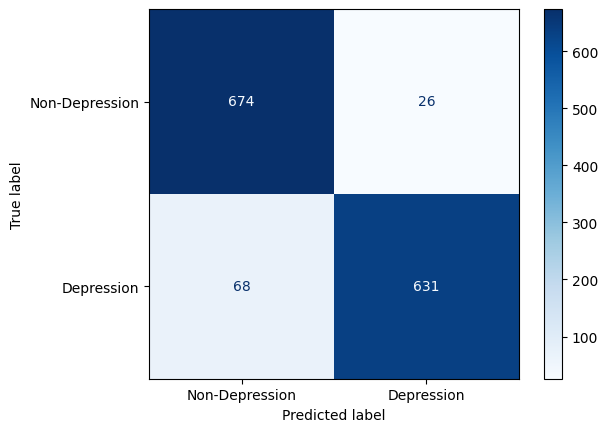

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# After the training is completed, you can make predictions on the validation set
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)  # Get predicted labels

# Extract true labels from val_dataset
y_true = np.array(val_dataset['label'])

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Depression', 'Depression'])
cm_display.plot(cmap='Blues')  # You can change the colormap
plt.title("Confusion Matrix")
plt.show()
